### Load the Commit Statistics
For this clustering we examined 39 GitHub projects containing a total of 2,629 commits. The projects all included the Fluence Marine library. Code for Fluence is generally written in React and Rust.

In [1]:
project_root_path = '../../..'
bob_lib_path = project_root_path + "/sandbox/python/bob/"

import json
import sys

sys.path.append(bob_lib_path)
import commit_stat_engineering

dataset_dir = project_root_path + '/data/github/2022-04-07-marine-search'
project_stats_dir = dataset_dir + '/projects'
all_commit_logs = commit_stat_engineering.find_files('commit-stat.log.json', project_stats_dir)
all_stats = commit_stat_engineering.get_stats_for_all_commits(all_commit_logs)

### Create Feature Sets
This cell creates three feature sets. This will let us look at the effect of removing one of the key features and including some of the supposedly unnecessary features.
* **X_minus:** This set is missing rustLines, which is one of the important features.
* **X_base:** This feature set has the optimal features identified in the feature engineering notebook.
* **X_plus:** Has three extra features that were found to be lacking during feature engineering.


In [2]:
import numpy as np
X_minus = [[np.log1p(stat['javascriptLines']),
            np.log1p(stat['jsonLines']),
            np.log1p(np.abs(stat['imgFiles'])),
            np.log1p(stat['lockLines']),
            np.log1p(stat['htmlLines'])] for stat in all_stats]

X_base = [[np.log1p(stat['javascriptLines']),
           np.log1p(stat['rustLines']),
           np.log1p(stat['jsonLines']),
           np.log1p(np.abs(stat['imgFiles'])),
           np.log1p(stat['lockLines']),
           np.log1p(stat['htmlLines'])] for stat in all_stats]

X_plus = [[np.log1p(stat['javascriptLines']),
           np.log1p(stat['rustLines']),
           np.log1p(stat['markdownLines']),
           np.log1p(stat['jsonLines']),
           np.log1p(np.abs(stat['imgFiles'])),
           np.log1p(stat['lockLines']),
           np.log1p(stat['yarnLines']),
           np.log1p(stat['clojureLines']),
           np.log1p(stat['htmlLines']),] for stat in all_stats]


### Predict Cluster Membership
Create a K-Means clustering for each set of input features.

In [3]:
from sklearn.cluster import KMeans

clusters = 3
random = 0

y_pred_minus = KMeans(n_clusters=clusters, random_state=random).fit_predict(X_minus)
y_pred_base = KMeans(n_clusters=clusters, random_state=random).fit_predict(X_base)
y_pred_plus = KMeans(n_clusters=clusters, random_state=random).fit_predict(X_plus)

### Reassign The Cluster IDs
This methood reassigns the cluster IDs in y_pred_minus so the colors will match the other two clusterings.

In [4]:
for i in range(len(y_pred_minus)):
    if y_pred_minus[i] == 1: y_pred_minus[i] = 3
    if y_pred_minus[i] == 2: y_pred_minus[i] = 1
    if y_pred_minus[i] == 3: y_pred_minus[i] = 2

In [5]:
import matplotlib.pyplot as plt

x_values = [np.log1p(stat['textLines']) for stat in all_stats]
y_values = [np.log1p(stat['totalFiles']) for stat in all_stats]

def plot(axis, y_pred, feature_set_name):
    axis.scatter(x_values, y_values, c=y_pred, cmap='Set1')#, title=feature_set_name)
    axis.set_title(feature_set_name)

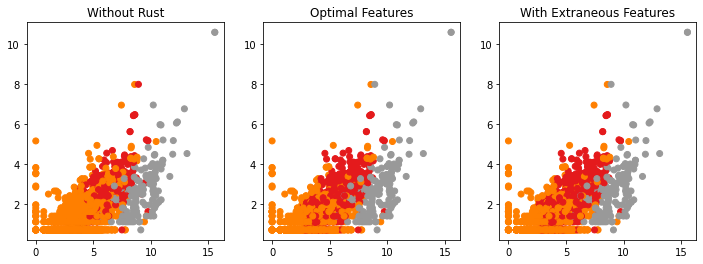

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
plot(axs[0], y_pred_minus, 'Without Rust')
plot(axs[1], y_pred_base, 'Optimal Features')
plot(axs[2], y_pred_plus, 'With Extraneous Features')
plt.show()

### Interpretation of Three Clusterings
When we leave a key feature, Rust Lines, out of the clustering, the resulting clusters are visibly different from the clustering with the optimal features. When we add in extraneous features, we find that the clusters are unaffected.

This is valuable information. K-Means is not sensitive to extraneous information and lends credibility to the notion that those features are not contributing important information.

Our next model will be a classifier which tends to be more sensitive to extraneous information. By confirming that we are safe to remove those features, we reduce the risk of classifier overfitting.

### More Complex Clustering
The 3-type clustering was used to analyze the input features. Now we can take a look at a more complex clustering, to see if we're getting good meaning out.

Unsupervised learning is not particularly precise, it would be unrealistic to expect a high definition image. If we get something that is somewhat meaningful, it will give us confidence to invest in the the labor-intensive labelling needed for supervised learning.

In [12]:
from sklearn.cluster import KMeans

num_clusters = 7
random = 0

X = X_base
y_pred = KMeans(n_clusters=num_clusters, random_state=random).fit_predict(X)

### Histogram of Cluster Sizes
It looks like our cluster sizes are exhibiting logarithmic decay. Ordering the clusters by decreasing size it looks like each cluster is about 0.6x the size of the previous cluster. It never ceases to amaze me how often I see mathematical functions like this in real-world data that do not seem to be mathematically coupled. Chaos can be beautiful.

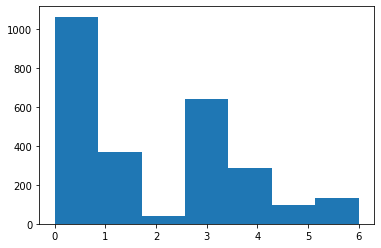

In [13]:
plt.hist(y_pred, num_clusters)
plt.show()

### Reshape the Stats for Easier Handling

In [14]:
for i in range(0, len(y_pred)):
    all_stats[i]['cluster'] = y_pred[i]
    
clusters = [i for i in range(0, num_clusters)]
for i in range(0, num_clusters):
    clusters[i] = [stats for stats in all_stats if stats['cluster'] == i]

### Show Median Statistics for Each Cluster
The table generated here has median values for each cluster to facilitate interpetation of the data. The output fields shown were not included directly as input features, though they are dependent variables.

In [17]:
import numpy as np
import pandas as pd

cluster_names = ['#' + str(i) for i in range(0,len(clusters))]
fields = ['numCommits', 'binFiles', 'textFiles', 'textLines',
          'javascriptLinePct', 'rustLinePct', 'markdownLinePct', 'jsonLinePct',
          'imgFilePct', 'lockLinePct', 'yarnLinePct', 'htmlLinePct']

for cluster in clusters:
    numCommits = len(cluster)
    for stats in cluster:
        stats['numCommits'] = numCommits

data = [[int(np.round(np.median([stats[field] for stats in cluster]))) for field in fields] for cluster in clusters]
cluster_df = pd.DataFrame(data, index=cluster_names, columns=fields)
cluster_df.transpose()

,#0,#1,#2,#3,#4,#5,#6
numCommits,1063,370,40,641,287,95,133
binFiles,0,0,3,0,0,0,0
textFiles,1,10,42,4,2,1,7
textLines,6,322,31048,57,90,45,4705
javascriptLinePct,0,0,2,0,100,0,1
rustLinePct,0,38,0,100,0,0,0
markdownLinePct,0,0,0,0,0,0,0
jsonLinePct,0,0,86,0,0,0,96
imgFilePct,0,0,4,0,0,0,0
lockLinePct,0,54,3,0,0,0,0


### Interpreting the Clusters

Each datapoint above is a median value of the commits in the cluster. This gives a good idea of what the cluster is about, though there may be devils in the details.

#### Cluster #0: Bugfixes & Tweaks
These are small commits that address a single problem. Often code, but could be documentation also. Since the chart shows median values and these will be mixed type commits, no single file type has a median over 0. This is the most common type of commit in our observed set.

#### Cluster #1: Rust Development and Packaging Commits
These commits include about as much Rust code as we would see in a Rust Development Commit, but they also have some "lock" text. ".lock" files are associated with the Rust package manager, called Cargo.

#### Cluster #2: Bulk Commits
These large commits include both text and binary data. These commits might include platform code, template code, or unpacked 3rd party toolkits.

#### Cluster #3: Rust Development Commits
These commits have a median value of 57 lines, all Rust. These are ordinary Rust developer commits.

#### Cluster #4: Javascript Development Commits
These commits have a median value of 82 lines, all Javascript. These are ordinary Javascript developer commits.

#### Cluster #5: HTML Development Commits
These commits have a median value of 45 lines, all HTML (including CSS). These are ordinary web interface developer commits.

#### Cluster #6: Big JSON Commits
These may be related to the bi-modal distribution of JSON lines that we saw during feature engineering. Diving deeper on the cause of that peculiar distribution should shed more light on the issue.
